# Import Packages and Read Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from pandas_profiling import ProfileReport

In [7]:
df_train = pd.read_csv('data/train_accounts.csv')
df_test = pd.read_csv('data/test_accounts.csv')
df_transactions = pd.read_csv('data/transactions.csv')

In [8]:
train_list = df_train.account.to_list()
test_list = df_test.account.to_list()
whole_list = train_list + test_list

print('Training records:', len(train_list), 'Testing records', len(test_list))
print('Total records:', len(whole_list), len(set(whole_list)))

fraud_list = df_train[df_train.flag == 1].account.to_list()
print('Fraud records:', len(fraud_list))

Training records: 25198 Testing records 6300
Total records: 31498 31498
Fraud records: 2455


In [9]:
print(df_transactions.shape)
print(df_transactions.from_account.nunique(), df_transactions.to_account.nunique())

(5826604, 6)
604847 419535


## Preprocessing

In [10]:
print(df_transactions.isnull().sum())

from_account            0
to_account              0
transaction_time_utc    0
value                   0
gas                     0
gas_price               0
dtype: int64


In [11]:
df_transactions.transaction_time_utc = pd.to_datetime(df_transactions.transaction_time_utc)
df_transactions['transaction_year'] = df_transactions.transaction_time_utc.dt.year.astype(int)
df_transactions['transaction_month_year'] = df_transactions.transaction_time_utc.dt.to_period('M')
df_transactions['transaction_date'] = df_transactions.transaction_time_utc.dt.date

In [12]:
df_transactions['gas_price'] = df_transactions['gas_price'].div(1000000000)
df_transactions['gas_fee'] = df_transactions['gas'].mul(df_transactions['gas_price'])
df_transactions['gas_fee'].describe()

count    5.826604e+06
mean     1.526253e+07
std      9.673410e+07
min      0.000000e+00
25%      4.590000e+05
50%      1.890000e+06
75%      9.000000e+06
max      6.923966e+10
Name: gas_fee, dtype: float64

In [16]:
df_transactions = df_transactions.assign(count_flag=1)
df_transactions['is_token'] = np.where(df_transactions['value']=='0', 1, 0)
df_transactions['value_digit'] = df_transactions.value.apply(lambda x: len(x))

In [14]:
df_transactions_part_1 = df_transactions.copy()

In [19]:
df_transactions.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,gas,gas_price,transaction_year,gas_fee,count_flag,is_token,value_digit
count,5826604.00,5826604.00,5826604.00,5826604.00,5826604.00,5826604.00,5826604.00
mean,245096.38,55.44,2019.30,15262534.33,1.00,0.63,7.17
std,537469.03,208.43,1.05,96734096.46,0.00,0.48,8.11
min,21000.00,0.00,2016.00,0.00,1.00,0.00,1.00
25%,50000.00,6.00,2019.00,459000.00,1.00,0.00,1.00
50%,90000.00,20.00,2020.00,1890000.00,1.00,1.00,1.00
75%,250000.00,60.00,2020.00,9000000.00,1.00,1.00,17.00
max,12022226.00,171397.02,2021.00,69239660614.74,1.00,1.00,23.00


# Dataset Construction

## Feature Engineering

1. from account features
2. to account features

- maximum, mean, std transaction number within the same date / month / year
- total number of transaction
- year count
- from/to account identified as fraud count
- total number of token/non-token transaction
- max, min, mean, std of gas price / gas / gas_fee
- max, min, mean, std of transaction value_digit

In [11]:
df_transactions.columns

Index(['from_account', 'to_account', 'transaction_time_utc', 'value', 'gas',
       'gas_price', 'transaction_year', 'transaction_month_year',
       'transaction_date', 'gas_fee', 'count_flag', 'is_token', 'value_digit'],
      dtype='object')

In [12]:
df_all = pd.DataFrame(data={'account': whole_list})
df_all = df_all.assign(src_dst_account_fraud_or_not=0)

usable_var = ['transaction_date', 'transaction_year', 'transaction_month_year',
              'gas', 'gas_price', 'gas_fee', 'is_token', 'value_digit', 'count_flag']

for var in ['src', 'dst']:
    if var == 'src':
        account_feature = 'from_account'
        counter_feature = 'to_account'
    else:
        account_feature = 'to_account'
        counter_feature = 'from_account'

    # maximum, mean, std transaction number within the same date / month / year
    for criteria in ['transaction_date', 'transaction_month_year', 'transaction_year']:
        df_temp = df_transactions.groupby([account_feature, criteria]).count_flag.count()
        df_temp_max = df_temp.reindex().groupby([account_feature]).max()
        df_temp_max = df_temp_max.rename(f'{var}_max_records_by_{criteria}').reset_index()
        df_temp_mean = df_temp.reindex().groupby([account_feature]).mean()
        df_temp_mean = df_temp_mean.rename(f'{var}_mean_records_by_{criteria}').reset_index()
        df_temp_std = df_temp.reindex().groupby([account_feature]).std(ddof=0)
        df_temp_std = df_temp_std.rename(f'{var}_std_records_by_{criteria}').reset_index()

        df_all = df_all.merge(df_temp_max, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_mean, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_std, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

    # total number of transaction
    df_temp_tot = df_transactions.groupby([account_feature]).count_flag.count()
    df_temp_tot = df_temp_tot.rename(f'{var}_total_transactions').reset_index()
    df_all = df_all.merge(df_temp_tot, how='left', left_on='account',
                          right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

    # year count
    df_temp_year = df_transactions.groupby([account_feature]).transaction_year.nunique()
    df_temp_year = df_temp_year.rename(f'{var}_year_count').reset_index()
    df_all = df_all.merge(df_temp_year, how='left', left_on='account',
                          right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

    # from/to account identified as fraud count: 0 is unknown / not fraud
    df_temp_fraud = df_transactions.merge(df_train, how='left', left_on=counter_feature,
                                          right_on='account').drop(columns='account')
    df_temp_fraud = df_temp_fraud.groupby([account_feature]).flag.max()
    df_temp_fraud = df_temp_fraud.rename(f'flag_{var}').reset_index().fillna(0)
    df_all = df_all.merge(df_temp_fraud, how='left', left_on='account',
                          right_on=account_feature).drop(columns=account_feature)
    df_all['src_dst_account_fraud_or_not'] = np.where(df_all[f'flag_{var}']==1,
                                                      1, df_all['src_dst_account_fraud_or_not'])

    # total number of token/non-token transaction
    df_temp_token = df_transactions.groupby([account_feature]).is_token.sum()
    df_temp_token = df_temp_token.rename(f'{var}_token_record_count').reset_index()
    df_all = df_all.merge(df_temp_token, how='left', left_on='account',
                          right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

    # max, min, mean, std of gas price / gas / gas_fee
    for feature in ['gas', 'gas_price', 'gas_fee']:
        df_temp_max = df_transactions.groupby([account_feature])[feature].max()
        df_temp_max = df_temp_max.rename(f'{var}_max_{feature}').reset_index()
        df_temp_min = df_transactions.groupby([account_feature])[feature].min()
        df_temp_min = df_temp_min.rename(f'{var}_min_{feature}').reset_index()
        df_temp_mean = df_transactions.groupby([account_feature])[feature].mean()
        df_temp_mean = df_temp_mean.rename(f'{var}_mean_{feature}').reset_index()
        df_temp_std = df_transactions.groupby([account_feature])[feature].std(ddof=0)
        df_temp_std = df_temp_std.rename(f'{var}_std_{feature}').reset_index()

        df_all = df_all.merge(df_temp_max, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_min, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_mean, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_std, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

    # max, min, mean, std of transaction value_digit
    for feature in ['value_digit']:
        df_temp_max = df_transactions.groupby([account_feature])[feature].max()
        df_temp_max = df_temp_max.rename(f'{var}_max_{feature}').reset_index()
        df_temp_min = df_transactions.groupby([account_feature])[feature].min()
        df_temp_min = df_temp_min.rename(f'{var}_min_{feature}').reset_index()
        df_temp_mean = df_transactions.groupby([account_feature])[feature].mean()
        df_temp_mean = df_temp_mean.rename(f'{var}_mean_{feature}').reset_index()
        df_temp_std = df_transactions.groupby([account_feature])[feature].std(ddof=0)
        df_temp_std = df_temp_std.rename(f'{var}_std_{feature}').reset_index()

        df_all = df_all.merge(df_temp_max, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_min, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_mean, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
        df_all = df_all.merge(df_temp_std, how='left', left_on='account',
                              right_on=account_feature).drop(columns=account_feature)
    df_all = df_all.fillna(0)

In [13]:
df_all_part2 = df_all.copy()
df_all_part2.to_pickle('data/df_all_part2.pkl')

In [14]:
display(df_all.isnull().mean().to_frame(name='null_pct').sort_values('null_pct', ascending=False).T)
display(df_all.describe())

,account,src_dst_account_fraud_or_not,dst_mean_records_by_transaction_date,dst_std_records_by_transaction_date,dst_max_records_by_transaction_month_year,dst_mean_records_by_transaction_month_year,dst_std_records_by_transaction_month_year,dst_max_records_by_transaction_year,dst_mean_records_by_transaction_year,dst_std_records_by_transaction_year,...,src_max_gas_price,src_min_gas_price,src_mean_gas_price,src_std_gas_price,src_max_gas_fee,src_min_gas_fee,src_mean_gas_fee,src_std_gas_fee,src_max_value_digit,dst_std_value_digit
null_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,src_dst_account_fraud_or_not,src_max_records_by_transaction_date,src_mean_records_by_transaction_date,src_std_records_by_transaction_date,src_max_records_by_transaction_month_year,src_mean_records_by_transaction_month_year,src_std_records_by_transaction_month_year,src_max_records_by_transaction_year,src_mean_records_by_transaction_year,src_std_records_by_transaction_year,...,dst_mean_gas_price,dst_std_gas_price,dst_max_gas_fee,dst_min_gas_fee,dst_mean_gas_fee,dst_std_gas_fee,dst_max_value_digit,dst_min_value_digit,dst_mean_value_digit,dst_std_value_digit
count,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,31498.000000,...,31498.000000,31498.000000,3.149800e+04,3.149800e+04,3.149800e+04,3.149800e+04,31498.000000,31498.000000,31498.000000,31498.000000
mean,0.022954,7.625056,2.214283,1.375487,28.888564,11.281139,8.700305,66.339450,43.096857,19.782068,...,44.848855,21.770248,1.103431e+07,1.051480e+06,2.612086e+06,1.972031e+06,17.606515,15.090799,16.636491,0.797434
std,0.149759,77.702994,9.856640,11.712608,351.726158,115.172637,114.144330,708.100917,528.918592,233.016010,...,56.288204,43.749636,8.235071e+07,4.148342e+06,7.441957e+06,7.895046e+06,3.651680,5.356001,3.814936,1.634922
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.000000,...,10.500000,0.000000,5.670000e+05,6.300000e+04,3.832634e+05,0.000000e+00,17.000000,16.000000,16.500000,0.000000
50%,0.000000,2.000000,1.166667,0.205381,4.000000,2.500000,0.707107,6.000000,5.000000,0.000000,...,26.439062,7.850542,2.205259e+06,2.625000e+05,1.092000e+06,3.551181e+05,18.000000,17.000000,17.500000,0.427790
75%,0.000000,4.000000,2.000000,0.829156,10.000000,5.000000,2.943920,22.000000,15.666667,3.741657,...,55.434643,25.981440,7.500000e+06,8.781150e+05,2.566087e+06,1.661411e+06,19.000000,18.000000,18.250000,0.742307
max,1.000000,6308.000000,854.777778,1062.457950,40397.000000,8366.142857,13772.158389,58563.000000,58563.000000,12085.018628,...,1210.420130,2144.796031,6.492470e+09,2.000000e+08,3.107304e+08,5.918665e+08,23.000000,23.000000,23.000000,10.000000


## EDA

- explore distribution: implement log transformation
- profiling, correlation plot

In [15]:
print(df_all.columns)

Index(['account', 'src_dst_account_fraud_or_not',
       'src_max_records_by_transaction_date',
       'src_mean_records_by_transaction_date',
       'src_std_records_by_transaction_date',
       'src_max_records_by_transaction_month_year',
       'src_mean_records_by_transaction_month_year',
       'src_std_records_by_transaction_month_year',
       'src_max_records_by_transaction_year',
       'src_mean_records_by_transaction_year',
       'src_std_records_by_transaction_year', 'src_total_transactions',
       'src_year_count', 'flag_src', 'src_token_record_count', 'src_max_gas',
       'src_min_gas', 'src_mean_gas', 'src_std_gas', 'src_max_gas_price',
       'src_min_gas_price', 'src_mean_gas_price', 'src_std_gas_price',
       'src_max_gas_fee', 'src_min_gas_fee', 'src_mean_gas_fee',
       'src_std_gas_fee', 'src_max_value_digit', 'src_min_value_digit',
       'src_mean_value_digit', 'src_std_value_digit',
       'dst_max_records_by_transaction_date',
       'dst_mean_records_by_t

In [16]:
df_all = pd.read_pickle('data/df_all_part2.pkl')

usable_var = ['account', 'src_dst_account_fraud_or_not',
              'src_max_records_by_transaction_date',
              'src_mean_records_by_transaction_date',
              'src_std_records_by_transaction_date',
              'src_max_records_by_transaction_month_year',
              'src_mean_records_by_transaction_month_year',
              'src_std_records_by_transaction_month_year',
              'src_max_records_by_transaction_year',
              'src_mean_records_by_transaction_year',
              'src_std_records_by_transaction_year',
              'src_total_transactions', 'src_year_count',
              'src_token_record_count',
              'src_max_gas', 'src_min_gas', 'src_mean_gas', 'src_std_gas',
              'src_max_gas_price', 'src_min_gas_price',
              'src_mean_gas_price', 'src_std_gas_price',
              'src_max_gas_fee', 'src_min_gas_fee',
              'src_mean_gas_fee', 'src_std_gas_fee',
              'src_max_value_digit', 'src_min_value_digit',
              'src_mean_value_digit', 'src_std_value_digit',
              'dst_max_records_by_transaction_date',
              'dst_mean_records_by_transaction_date',
              'dst_std_records_by_transaction_date',
              'dst_max_records_by_transaction_month_year',
              'dst_mean_records_by_transaction_month_year',
              'dst_std_records_by_transaction_month_year',
              'dst_max_records_by_transaction_year',
              'dst_mean_records_by_transaction_year',
              'dst_std_records_by_transaction_year',
              'dst_total_transactions', 'dst_year_count',
              'dst_token_record_count',
              'dst_max_gas', 'dst_min_gas', 'dst_mean_gas', 'dst_std_gas',
              'dst_max_gas_price', 'dst_min_gas_price',
              'dst_mean_gas_price', 'dst_std_gas_price',
              'dst_max_gas_fee', 'dst_min_gas_fee',
              'dst_mean_gas_fee', 'dst_std_gas_fee',
              'dst_max_value_digit', 'dst_min_value_digit',
              'dst_mean_value_digit', 'dst_std_value_digit']

log_var = ['src_max_gas', 'src_min_gas',
           'src_mean_gas', 'src_std_gas',
           'src_max_gas_price', 'src_min_gas_price',
           'src_mean_gas_price', 'src_std_gas_price',
           'src_max_gas_fee', 'src_min_gas_fee',
           'src_mean_gas_fee', 'src_std_gas_fee',
           'dst_max_gas', 'dst_min_gas',
           'dst_mean_gas', 'dst_std_gas',
           'dst_max_gas_price', 'dst_min_gas_price',
           'dst_mean_gas_price', 'dst_std_gas_price',
           'dst_max_gas_fee', 'dst_min_gas_fee',
           'dst_mean_gas_fee', 'dst_std_gas_fee']

df_all = df_all[usable_var]

In [17]:
df_all[log_var].isnull().mean()

src_max_gas           0.0
src_min_gas           0.0
src_mean_gas          0.0
src_std_gas           0.0
src_max_gas_price     0.0
src_min_gas_price     0.0
src_mean_gas_price    0.0
src_std_gas_price     0.0
src_max_gas_fee       0.0
src_min_gas_fee       0.0
src_mean_gas_fee      0.0
src_std_gas_fee       0.0
dst_max_gas           0.0
dst_min_gas           0.0
dst_mean_gas          0.0
dst_std_gas           0.0
dst_max_gas_price     0.0
dst_min_gas_price     0.0
dst_mean_gas_price    0.0
dst_std_gas_price     0.0
dst_max_gas_fee       0.0
dst_min_gas_fee       0.0
dst_mean_gas_fee      0.0
dst_std_gas_fee       0.0
dtype: float64

In [18]:
# profile = ProfileReport(df_all, title="Feature Report")
# profile.to_file("data/feature_profile.html")

In [19]:
for feature in log_var:
    df_all[feature] = np.log1p(df_all[feature])

df_all_part3 = df_all.copy()
df_all_part3.to_pickle('data/df_all_part3.pkl')

# Modelling

- implement models: regression, autoencoder, boosting, RNN

In [20]:
features =   ['src_dst_account_fraud_or_not',
              'src_max_records_by_transaction_date',
              'src_mean_records_by_transaction_date',
              'src_std_records_by_transaction_date',
              'src_max_records_by_transaction_month_year',
              'src_mean_records_by_transaction_month_year',
              'src_std_records_by_transaction_month_year',
              'src_max_records_by_transaction_year',
              'src_mean_records_by_transaction_year',
              'src_std_records_by_transaction_year',
              'src_total_transactions', 'src_year_count',
              'src_token_record_count',
              'src_max_gas', 'src_min_gas', 'src_mean_gas', 'src_std_gas',
              'src_max_gas_price', 'src_min_gas_price',
              'src_mean_gas_price', 'src_std_gas_price',
              'src_max_gas_fee', 'src_min_gas_fee',
              'src_mean_gas_fee', 'src_std_gas_fee',
              'src_max_value_digit', 'src_min_value_digit',
              'src_mean_value_digit', 'src_std_value_digit',
              'dst_max_records_by_transaction_date',
              'dst_mean_records_by_transaction_date',
              'dst_std_records_by_transaction_date',
              'dst_max_records_by_transaction_month_year',
              'dst_mean_records_by_transaction_month_year',
              'dst_std_records_by_transaction_month_year',
              'dst_max_records_by_transaction_year',
              'dst_mean_records_by_transaction_year',
              'dst_std_records_by_transaction_year',
              'dst_total_transactions', 'dst_year_count',
              'dst_token_record_count',
              'dst_max_gas', 'dst_min_gas', 'dst_mean_gas', 'dst_std_gas',
              'dst_max_gas_price', 'dst_min_gas_price',
              'dst_mean_gas_price', 'dst_std_gas_price',
              'dst_max_gas_fee', 'dst_min_gas_fee',
              'dst_mean_gas_fee', 'dst_std_gas_fee',
              'dst_max_value_digit', 'dst_min_value_digit',
              'dst_mean_value_digit', 'dst_std_value_digit']

In [21]:
df_all = pd.read_pickle('data/df_all_part3.pkl')
df_all = df_all.merge(df_train, how='left', on='account')

train_data = df_all[df_all.account.isin(train_list)].sort_values(by='account').reset_index(drop=True)
test_data = df_all[df_all.account.isin(test_list)].sort_values(by='account').reset_index(drop=True)

y_label  = 'flag'

X_train = train_data[features]
y_train = train_data[y_label]
X_test = test_data[features]

In [22]:
print(X_train.shape, X_test.shape)

(25198, 57) (6300, 57)


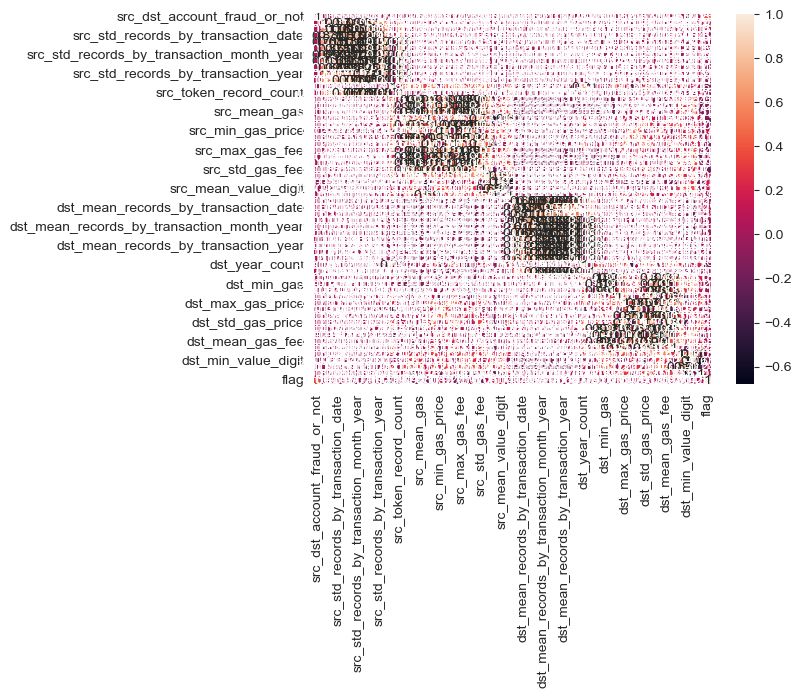

In [23]:
corr_matrix = train_data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.savefig('feature_correlation.png')
plt.show()

In [24]:
train_data.to_pickle('data/train_data.pkl')
test_data.to_pickle('data/test_data.pkl')
X_train.to_pickle('data/X_train.pkl')
y_train.to_pickle('data/y_train.pkl')
X_test.to_pickle('data/X_test.pkl')

## XGBoost

In [28]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from xgboost import plot_importance

import joblib
import warnings
warnings.filterwarnings('ignore')

C:\Users\Letian YU\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [71]:
def run_xgb(train_X, train_y, test_X):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    params = {'learning_rate': [0.05],
              'max_depth': [8],
              'subsample': [0.8],
              'gamma': [0],
              }

    model = xgb.XGBClassifier(n_estimators = 1000,
                              eval_metric=f1_score,
                              objective='binary:logistic',
                              random_state=42,
                              early_stopping_rounds=50,
                              )

    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        cv = cv,
                        n_jobs = 5,
                        scoring = 'f1',
                        refit = 'f1',
                        verbose = 5)

    grid.fit(train_X, train_y)
    plot_importance(grid.best_estimator_)
    test_y = grid.predict(test_X)

    print('Best Params:', grid.best_params_)
    print('Best Score:', grid.best_score_)
    print('Feature Importance:\n', grid.best_estimator_.feature_importances_)

    return grid, test_y

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[23:22:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:22:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 8, 'subsample': 0.8}
Best Score: 0.7531174300601771
Feature Importance:
 [0.15195884 0.01253832 0.0124441

['model/XGBoost_grid_6.pkl']

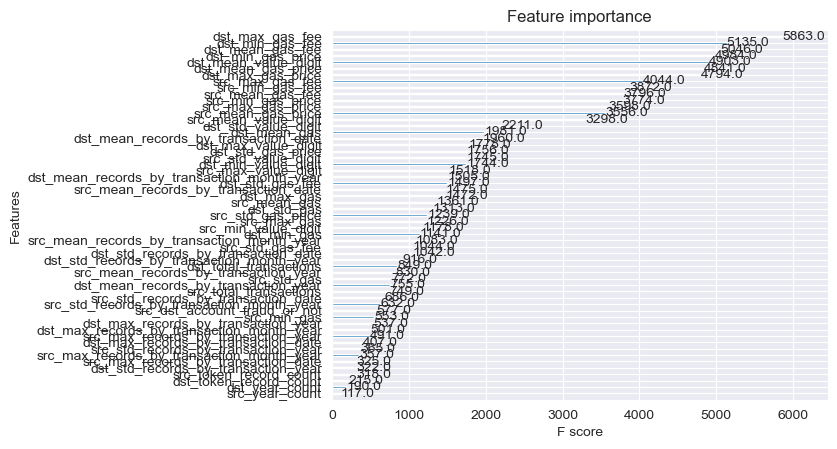

In [72]:
version = 6
grid_search, y_test = run_xgb(X_train, y_train, X_test)
joblib.dump(grid_search, f'model/XGBoost_grid_{version}.pkl')

In [73]:
submission_result = test_data.assign(flag=y_test)[['account','flag']]
submission_result.to_csv(f'submission_{version}.csv')

In [74]:
submission_result

,account,flag
0,a00003,0.0
1,a00011,0.0
2,a00012,1.0
3,a00020,0.0
4,a00021,0.0
...,...,...
6295,a31469,0.0
6296,a31477,0.0
6297,a31478,0.0
6298,a31480,0.0


## Logistic Regression

- Benchmark comparison

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def logistic_regression(train_X, train_y, test_X):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_reg = LogisticRegression(random_state=42, max_iter=5000)
    scores = cross_val_score(log_reg, train_X, train_y, cv=cv, scoring='f1')
    print('Cross-Validation Accuracy Scores', scores)

logistic_regression(X_train, y_train, X_test)

Cross-Validation Accuracy Scores [0.58885942 0.59337748 0.61971831 0.60422164 0.59820282]


## TSNE

In [66]:
from sklearn.manifold import TSNE

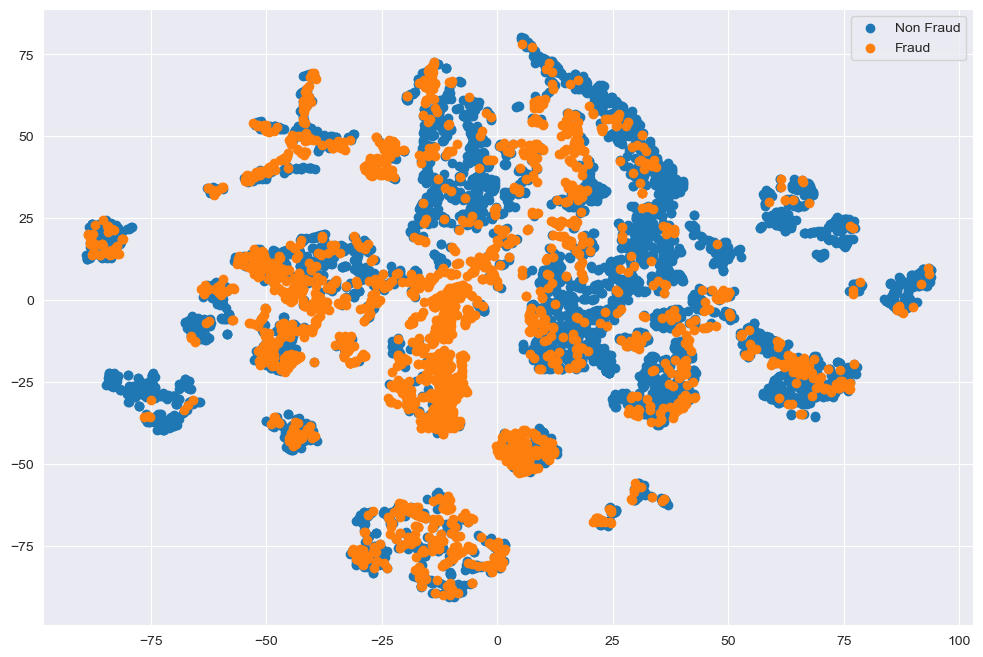

In [70]:
non_fraud = train_data[train_data['flag'] == 0].drop(columns='account').sample(5000)
fraud = train_data[train_data['flag'] == 1].drop(columns='account')

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['flag'], axis = 1).values
Y = df["flag"].values

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=42)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], label='Fraud')

    plt.legend();
    plt.show();

tsne_plot(X, Y)